Classificação de nível de desgaste a partir das frequências de ressonância

In [1]:
import os
from multiprocessing import Pool

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay

from DataImporter import achar_feathers, achar_ressonancias, agrupar_por_desgaste

In [2]:
RNG_SEED = 42
PASTA_DADOS = "/home/gabrielmc/Documentos/LINSE/Dados"

# Importação dos Dados
---

São identificados os dois primeiros harmônicos de cada amostra. Os dados utilizados estão disponíveis em https://drive.google.com/drive/folders/1PO2f4bMhO3MOGgz_Fo8y6pxQmCKuPypV?usp=sharing

In [3]:
all_feathers = achar_feathers(PASTA_DADOS)
sorted_feathers = agrupar_por_desgaste(all_feathers)

In [4]:
def import_data(feathers_catalogados: list[list[str]], imu: str) -> pd.DataFrame:
    dfs = []
    for desgaste_lvl, feathers in enumerate(feathers_catalogados):
        if feathers == [None]:
            continue # ignora níveis de desgaste sem amostras
        
        name_tags = [os.path.basename(feather)[:-8] for feather in feathers]
        inputs = [(i, imu) for i in feathers]
        with Pool() as pool:
            data = list(pool.starmap(achar_ressonancias, inputs))
        flat_data = [np.array(i)[:, :2].flatten() for i in data]
        index = pd.MultiIndex.from_product([[desgaste_lvl], name_tags], names= ["Desgaste", "Amostra"])
        dfs.append(pd.DataFrame(flat_data, index=index))
    
    return pd.concat(dfs)

In [5]:
dfs_ressonancias = []
for imu in ("imu1accz", "imu2accz"):
    dfs_ressonancias.append(import_data(sorted_feathers, imu))
df_ressonancias = pd.concat(dfs_ressonancias)
df_ressonancias.head()

0          1       2       3
Desgaste Amostra                                         
0        R2_A2_0.15 -32.506695 -24.644065  29.952  81.744
         R3_A2_0.75 -30.338431 -27.708322  29.744  81.744
         R3_A2_0.15 -32.627895 -24.083694  29.952  81.744
         R3_A2_0.4  -32.702030 -26.401221  29.744  81.536
         R3_A2_0.2  -32.236878 -26.275198  29.744  81.744

In [6]:
df_media = (dfs_ressonancias[0] + dfs_ressonancias[1]) / 2
df_media.head()

0          1       2       3
Desgaste Amostra                                         
0        R2_A2_0.15 -27.310629 -23.940298  29.952  81.744
         R3_A2_0.75 -25.156284 -26.992345  29.744  81.744
         R3_A2_0.15 -27.494724 -23.409126  29.848  81.744
         R3_A2_0.4  -27.552470 -25.676095  29.744  81.536
         R3_A2_0.2  -27.040265 -25.555047  29.848  81.744

In [7]:
df_aux = df_ressonancias.reset_index()
data = np.array(df_aux.drop(["Desgaste", "Amostra"], axis= 1))
labels = np.array(df_aux.loc[:, "Desgaste"])

x_treino, x_teste, y_treino, y_teste = train_test_split(data, labels, test_size=.2,
                                                    stratify=labels, random_state=RNG_SEED)

# Random Forest Classifier
---

In [8]:
modelo_rfc = RandomForestClassifier(random_state=RNG_SEED)
metricas = ["accuracy", "f1_macro", "precision_macro", "recall_macro"]
scores = cross_validate(modelo_rfc, x_treino, y_treino, scoring=metricas)

mensagem = f"""Média Accuracy: {np.mean(scores["test_accuracy"]):>8.2%}
DP Accuracy: {np.std(scores["test_accuracy"]):>11.2}
{'':-^25}
Média F1: {np.mean(scores["test_f1_macro"]):>14.2%}
Média Precision: {np.mean(scores["test_precision_macro"]):>7.2%}
Média Recall: {np.mean(scores["test_recall_macro"]):>10.2%}"""

print(mensagem)

Média Accuracy:   74.43%
DP Accuracy:       0.011
-------------------------
Média F1:         74.26%
Média Precision:  75.62%
Média Recall:     74.34%


In [9]:
modelo_rfc.fit(x_treino, y_treino)
predicao_rfc = modelo_rfc.predict(x_teste)

mensagem = f"""Accuracy: {accuracy_score(y_teste, predicao_rfc):>5.2%}
F1: {f1_score(y_teste, predicao_rfc, average='macro'):>12.2%}"""
print(mensagem)

Accuracy: 74.03%
F1:       74.16%


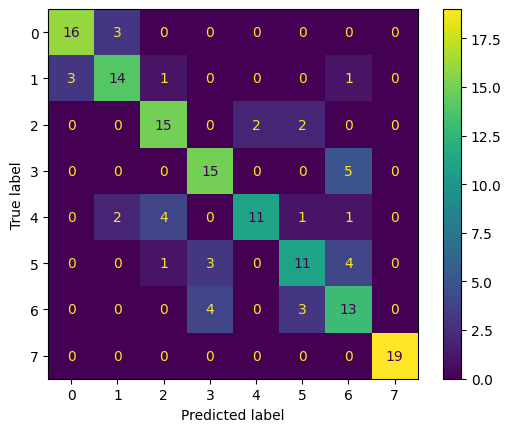

In [10]:
ConfusionMatrixDisplay.from_predictions(y_teste, predicao_rfc)
plt.show()